In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Module importing

In [2]:
# Data processing libraries
import pandas as pd
import numpy as np

# NLP libraries
import nltk
from nltk.tag import StanfordPOSTagger

# Machine Learning Libraries
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split # Parameter selection
import sklearn_crfsuite
from sklearn_crfsuite import scorers, metrics
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

# Other libraries
import time # Execution time of some blocks
import statistics
from IPython.display import display # For displaying DataFrames correctly in Jupyter
from itertools import chain
import collections

# Import our own defined functions
from xlm_parsers_functions import *
from drug_interaction_functions import *
from drug_functions import *
from NER_functions import *

/Users/cesc/Anaconda3/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/cesc/Anaconda3/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Reading the XML data

In [3]:
data_dir1 = 'data/Train/DrugBank/'
data_dir2 = 'data/Train/MedLine/'

def readXMLData(data_dir):

    # Use xlm_element.tag to get the name of the xlm element
    # Use xlm_element.attrib to get all the attributes of the xlm element as a string

    # Parse the DrugBank Files
    drugs_dataset = []
    #parent_directory = '../LaboCase/small_train_DrugBank/'
    for filename in os.listdir(data_dir):
        if filename.endswith(".xml"):
            # Parse the file
            tree = ET.parse(data_dir + filename)
            # Create a list of lists with the interactions of the file
            drugs_dataset = drugs_dataset + listDDIFromXML(tree.getroot())

    return(drugs_dataset)

# Create a list of lists with the interactions of the file
XMLdata_DrugBank = readXMLData(data_dir1)
XMLdata_MedLine = readXMLData(data_dir2)

XMLdata = XMLdata_DrugBank + XMLdata_MedLine

## Feature creation

In [4]:
with(open('data/DrugBank_names_DB.txt', 'r')) as f:
    drugbank_db = f.read().splitlines()
    
def sent2features(tupl, i, database):
    
    if len(tupl) != 5:
        raise ValueError('The introduced tuple does not have the correct length')
    sent = tupl[0]
    ent1 = tupl[1]
    ent2 = tupl[2]
    ent_list = tupl[3]
    
    features = {
        
    'ent1': ent1,
    'ent2': ent2,
    # Orthographic features
        
    # Entity 1
    'ent1_all_uppercase_letters' : allCaps(ent1), 
    'ent1_initial_capital_letter': initCap(ent1), 
    'ent1_contains_capital_letter' : hasCap(ent1),
    'ent1_single_capital_letter' : singleCap(ent1),
    'ent1_punctuation' : punctuation(ent1),
    'ent1_initial_digit' : initDigit(ent1),
    'ent1_single_digit' : singleDigit(ent1),
    'ent1_letter_and_num' : alphaNum(ent1),
    'ent1_many_numbers' : manyNum(ent1),
    'ent1_contains_real_numbers' : realNum(ent1),
    'ent1_intermediate_dash' : inDash(ent1),
    'ent1_has_digit' : hasDigit(ent1),
    'ent1_is_Dash' : isDash(ent1),
    'ent1_is_roman_letter' : roman(ent1),
    'ent1_is_end_punctuation' : endPunctuation(ent1),
    'ent1_caps_mix' : capsMix(ent1),

    # Entity 2
    'ent2_all_uppercase_letters' : allCaps(ent2), 
    'ent2_initial_capital_letter': initCap(ent2), 
    'ent2_contains_capital_letter' : hasCap(ent2),
    'ent2_single_capital_letter' : singleCap(ent2),
    'ent2_punctuation' : punctuation(ent2),
    'ent2_initial_digit' : initDigit(ent2),
    'ent2_single_digit' : singleDigit(ent2),
    'ent2_letter_and_num' : alphaNum(ent2),
    'ent2_many_numbers' : manyNum(ent2),
    'ent2_contains_real_numbers' : realNum(ent2),
    'ent2_intermediate_dash' : inDash(ent2),
    'ent2_has_digit' : hasDigit(ent2),
    'ent2_is_Dash' : isDash(ent2),
    'ent2_is_roman_letter' : roman(ent2),
    'ent2_is_end_punctuation' : endPunctuation(ent2),
    'ent2_caps_mix' : capsMix(ent2),
        
    # Morphological information: prefixes/suffixes of lengths from 2 to 5 and word shapes of tokens. 
    # Entity 1
    'ent1_word[-5:]': ent1[-5:],
    'ent1_word[-4:]': ent1[-4:],
    'ent1_word[-3:]': ent1[-3:],
    'ent1_word[-2:]': ent1[-2:],

    # Entity 2
    'ent2_word[-5:]': ent2[-5:],
    'ent2_word[-4:]': ent2[-4:],
    'ent2_word[-3:]': ent2[-3:],
    'ent2_word[-2:]': ent2[-2:],
    
    # Domain knowledge
    # Entity 1
    'ent1_contains_drug_sufix': containsSufix(ent1),
    'ent1_contains_drug_prefix': containsPrefix(ent1),

    # Entity 2
    'ent2_contains_drug_sufix': containsSufix(ent2),
    'ent2_contains_drug_prefix': containsPrefix(ent2),
        
    # Is in DrugBank dataset
    'ent1_isInDB':isTokenInDB(ent1,database),
    'ent2_isInDB':isTokenInDB(ent2,database)
    }

    return features


def text2features(text,database):
    for i in range(len(text)):
        return(sent2features(text, i, drugbank_db))

def text2labels(text):
    return text[4]

In [5]:
%%time
X = [[text2features(s, drugbank_db)] for s in XMLdata]
y = [[text2labels(s)] for s in XMLdata]

CPU times: user 7.95 s, sys: 115 ms, total: 8.06 s
Wall time: 8.17 s


## Train/Test/Validation split

For this project, we will split the original dataset in the following proportions:
 - Training data: 42%
 - Testing data: 40%
 - Validation data: 18%

In [6]:
seed = 16273
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=seed, shuffle = True)
print('Number of training sentences: ', len(X_train))
print('Number of testing sentences: ', len(X_test))

Number of training sentences:  11672
Number of testing sentences:  11117


## Hyperparameter Optimization


Using validation data

In [7]:
%%time
# We don't want to include the 'none' label for the optimization
labels = ['mechanism', 'effect', 'int', 'advise']

# Define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=20,
                        scoring=f1_scorer)
rs.fit(X_val, y_val)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   24.4s finished


CPU times: user 4.29 s, sys: 208 ms, total: 4.5 s
Wall time: 25.7 s


In [8]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.16186864078444804, 'c2': 0.021301324566858997}
best CV score: 0.23612682199497317
model size: 0.26M


Dark blue => 0.1161, dark red => 0.2361


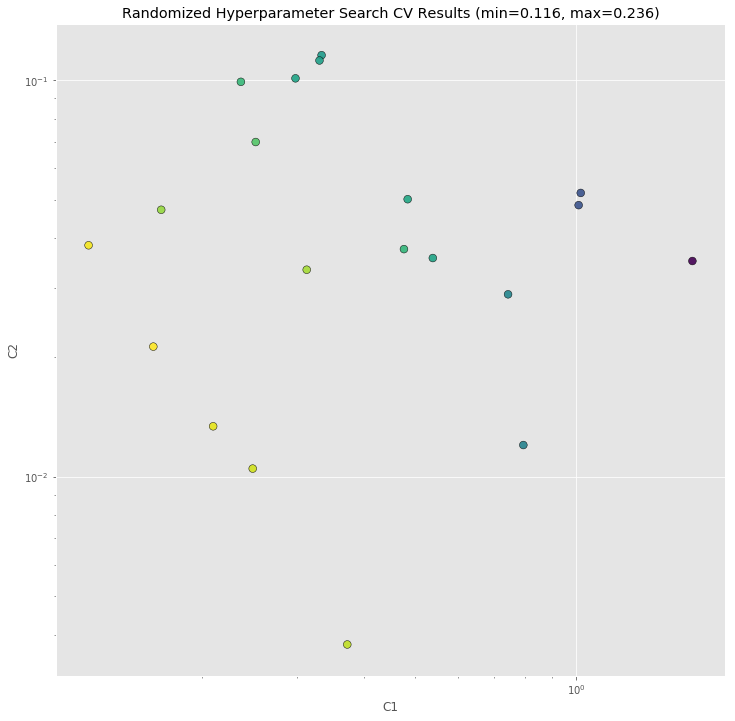

In [9]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

## Model training
Using training data and the parameters obtained in the previous step

In [10]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=rs.best_params_['c1'],
    c2=rs.best_params_['c2'],
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)

CPU times: user 2.46 s, sys: 42.3 ms, total: 2.5 s
Wall time: 2.5 s


## Evaluation

Using test data

In [11]:
y_pred = crf.predict(X_test)

In [12]:
for i in range(len(y_pred)):
    if y_pred[i][0] is None:
        print('y_pred index: ', i)
        y_pred[i][0] = 'none'
    
    if y_test[i][0] is None:
        print('y_test index:' , i)
        y_test[i][0] = 'none'

y_test index: 3428


In [13]:
print(sklearn.metrics.recall_score(y_true = y_test, 
                             y_pred = y_pred, 
                             labels=labels, 
                             pos_label=1, 
                             average='weighted',
                             sample_weight=None)
      )

print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels, digits=3
))

0.323934837093
             precision    recall  f1-score   support

  mechanism      0.503     0.279     0.359       537
     effect      0.553     0.382     0.452       646
        int      0.737     0.512     0.604        82
     advise      0.494     0.236     0.319       331

avg / total      0.533     0.324     0.401      1596



In [14]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(collections.Counter(crf.state_features_).most_common(15))

print("\nTop negative:")
print_state_features(collections.Counter(crf.state_features_).most_common()[-15:])

Top positive:
7.023777 effect   ent2:Mefloquine
6.952814 effect   ent1:nondepolarizing agents
6.926544 effect   ent1:Folic acid
6.761575 effect   ent2:Meclofenamate sodium
6.757512 mechanism ent1:Bile acid binding resins
6.496515 effect   ent2:5-HT1 agonists
6.316003 advise   ent1:anileridine
6.231492 mechanism ent1:levothyroxine sodium
6.174144 advise   ent1:HMG-CoA reductase inhibitor
6.129222 advise   ent1:MAO-inhibitors
6.090871 advise   ent1:Azlocillin
5.857037 mechanism ent2:combination hormonal contraceptives
5.841964 int      ent1:Etonogestrel
5.680914 advise   ent1:cinoxacin
5.675120 effect   ent1:Diuretic agents

Top negative:
-2.632113 none     ent2:heparin sodium
-2.710721 none     ent1:piperazine
-2.754610 none     ent1:retinoids
-2.948144 none     ent1:Barbiturates
-2.970497 none     ent1:butorphanol
-3.155482 none     ent1:EQUETROTM
-3.171576 none     ent2:hypoglycemic agents
-3.186105 none     ent1:Aminoglutethimide
-3.230639 none     ent1:Corticotropin
-3.247165 none  

In [15]:
'''
def transformStrCategoriesIntoInts(vector):
    res = []
    for el in vector:
        if el == 'none' or el == 'None':
            res.append(0)
        elif el == 'mechanism':
            res.append(1)
        elif el == 'effect':
            res.append(2)
        elif el == 'int':
            res.append(3)
        elif el == 'advise':
            res.append(4)
        else:
            print(el)
            print(type(el))
            print(vector.index(el))
    return(res)
'''

"\ndef transformStrCategoriesIntoInts(vector):\n    res = []\n    for el in vector:\n        if el == 'none' or el == 'None':\n            res.append(0)\n        elif el == 'mechanism':\n            res.append(1)\n        elif el == 'effect':\n            res.append(2)\n        elif el == 'int':\n            res.append(3)\n        elif el == 'advise':\n            res.append(4)\n        else:\n            print(el)\n            print(type(el))\n            print(vector.index(el))\n    return(res)\n"